# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ML_lib
import importlib
import os

# for debug purposes, reload the module to reflect recent changes
importlib.reload(ML_lib)

<module 'ML_lib' from 'c:\\Users\\maxim\\Godot Games\\Snake\\python-test-folder\\ML_lib.py'>

# Loading CSV data

In [2]:
def load_and_preprocess_data(data_path):
    # iterate over all the csv files in the data_path, remove the header and combine them into one np.array
    data_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
    data_list = []

    print(f"Found {len(data_files)} csv files in {data_path}")

    for file in data_files:
        file_path = os.path.join(data_path, file)
        try:
            data = np.loadtxt(file_path, delimiter=',', skiprows=1)
            if data.size > 0:
                # Ensure 2D array even if single line
                if len(data.shape) == 1:
                    data = data.reshape(1, -1)
                
                #'No Input' ([0,0,0,0]) changed to Last Direction
                # Default to [0, 1, 0, 0] (Right), the game starts with no input
                last_action = np.array([0, 1, 0, 0], dtype=data.dtype)

                for i in range(len(data)):
                    # Check the last 4 columns (targets)
                    current_y = data[i, -4:]
                    
                    # If sum is 0, it means no key was pressed -> Snake continues previous direction
                    if np.sum(current_y) == 0:
                        data[i, -4:] = last_action
                    else:
                        # New input found, update the last known action
                        last_action = current_y

                data_list.append(data)
        except Exception as e:
            print(f"Error loading {file}: {e}")

    if not data_list:
        print("No data loaded.")
        return None, None

    combined_data = np.concatenate(data_list, axis=0)
    print(f"Original combined shape: {combined_data.shape}")

    # Filter rows where score (col 1) resets to 0 in the next row, but is not 0 itself
    # Allow to remove the actions that lead to game over
    # Logic: (current_score != 0) AND (next_score == 0) -> Remove current
    
    to_remove = np.zeros(len(combined_data), dtype=bool)
    
    # Check condition for all rows except the last one
    # Column 1 is the score column
    to_remove[:-1] = (combined_data[:-1, 1] != 0) & (combined_data[1:, 1] == 0)
    
    num_removed = np.sum(to_remove)
    print(f"Removing {num_removed} rows where score resets to 0.")
    
    if num_removed > 0:
        final_scores = combined_data[to_remove, 1]
        avg_score = np.mean(final_scores)
        max_score = np.max(final_scores)
        print(f"Statistics over {num_removed} games:")
        print(f"  - Average Score: {avg_score:.2f}")
        print(f"  - Max Score: {max_score}")
    else:
        print("No game resets detected (Average Score cannot be computed).")

    combined_data_filtered = combined_data[~to_remove]
    
    # Remove the first column (index 0) gameOver not relevant
    combined_data_final = combined_data_filtered[:, 1:]
    
    print(f"Shape after filtering rows and removing first column: {combined_data_final.shape}")

    # use the last 4 row as the prediction and the rest as the features
    X = combined_data_final[:, :-4]
    Y = combined_data_final[:, -4:]

    print(f"Final X shape: {X.shape}")
    print(f"Final Y shape: {Y.shape}")
    
    # print the size of X in MB
    print("Size of X: ", X.nbytes / 1e6, "MB")
    
    return X, Y

In [3]:
X, Y = load_and_preprocess_data("../Data/")

Found 4 csv files in ../Data/
Original combined shape: (46845, 525)
Removing 149 rows where score resets to 0.
Statistics over 149 games:
  - Average Score: 17.53
  - Max Score: 67.0
Shape after filtering rows and removing first column: (46696, 524)
Final X shape: (46696, 520)
Final Y shape: (46696, 4)
Size of X:  194.25536 MB


In [4]:
NPL = [520, 128, 64, 4]

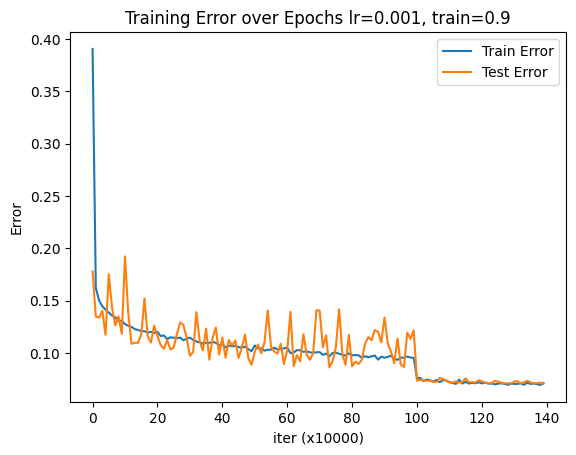

In [7]:
mlp = ML_lib.MLP(NPL, True)

num_iter = 1_000_000
error_list_size = 100
lr = 0.01
train_proportion = 0.9

train_err, test_err = mlp.train(X.T, Y.T, num_iter = num_iter, lr=lr, 
                            train_proportion=train_proportion, error_list_size=error_list_size)

num_iter = 400_000
error_list_size = 40
lr = 0.001

train_err_low_lr, test_err_low_lr = mlp.train(X.T, Y.T, num_iter = num_iter, lr=lr, 
                            train_proportion=train_proportion, error_list_size=error_list_size)

# happend the train_err_low_lr at the end of the train_err
train_err = np.concatenate((train_err, train_err_low_lr))
test_err = np.concatenate((test_err, test_err_low_lr))

plt.plot(train_err, label="Train Error")
plt.plot(test_err, label="Test Error")
plt.xlabel(f"iter (x{num_iter//error_list_size})")
plt.ylabel("Error")
plt.title(f"Training Error over Epochs lr={lr}, train={train_proportion}")
plt.legend()
plt.show()

In [8]:
# Predict 10 random samples from X and print them and the corresponding Y
for idx in range(10):
    x_sample = X[idx, :].reshape(-1, 1)
    y_true = Y[idx, :].reshape(-1, 1)
    y_pred = mlp.predict(x_sample)
    print(f"Sample {idx}:")
    print(f"  True Output: {y_true.ravel()}")
    print(f"  Predicted Output: {y_pred.ravel()}")

Sample 0:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.05842434 0.52301798 0.22113837 0.12663811]
Sample 1:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.05139917 0.51114077 0.24398375 0.1159494 ]
Sample 2:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.06664092 0.46352991 0.26684166 0.11441575]
Sample 3:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.06116318 0.46611242 0.28229877 0.10565157]
Sample 4:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.04952163 0.43507412 0.39065578 0.09675342]
Sample 5:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [-2.90180256e-04  3.12959893e-01  6.43890576e-01  6.16731747e-02]
Sample 6:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.03694894 0.40533867 0.35223938 0.11438924]
Sample 7:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.0539913  0.38675535 0.33073042 0.12006684]
Sample 8:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.02622369 0.36435895 0.50798128 0.08799746]
Sample 9:
  True Output: [0. 1. 0. 

In [ ]:
path = f"..\\Models\\{X.shape[0]}X_{NPL}_{num_iter}iter_{lr}lr_{train_proportion}train.bin"
mlp.save(path)
print(f"Model saved to {path}")

Model saved to ..\Models\46696X_[520, 128, 64, 4]_1400000iter_0.01+0.001lr_0.9train.bin
